# Work done by pair of students

- Nico Sharei (nsharei)
- Artem Bisliouk (abisliou)

In [1]:
#
# IE 678 Deep Learning, University of Mannheim
# Author: Rainer Gemulla
# Edited by: Artem Bisliouk, Nico Sharei

In [2]:
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

# import helper functions
import sys, os

sys.path.append(os.getcwd())
from a01helper import *  # check out the helper functions there, if you like

# Task 1: Implement an MLP

## 1a Logistic Regression

In [3]:
# nn.Module is the superclass of all PyTorch models.
class LogisticRegression(nn.Module):
    """A logistic regression model.

    Parameters
    ----------
    D number of inputs
    C number of classes
    """

    # the definition of all parameters the model uses happens here, i.e., during
    # initialization
    def __init__(self, D, C):
        super(LogisticRegression, self).__init__()

        # Create and initialize model parameters. For (multinomial) logistic regression,
        # we have a DxC-dimensional weight matrix W and a C-dimensional bias b.
        self.W = torch.randn(D, C) / math.sqrt(D)
        self.b = torch.randn(C) / math.sqrt(C)

        # Model parameters must be registered to PyTorch as follows. Here we provide
        # a useful name that helps to access/analyze the model later on.
        self.register_parameter("0_weight", nn.Parameter(self.W))
        self.register_parameter("0_bias", nn.Parameter(self.b))

    # the forward function computes the model output for the provided (for this
    # assignent: single) input
    def forward(self, x):
        eta = self.W.t() @ x + self.b
        logprob = F.log_softmax(eta, dim=-1)
        return logprob

In [4]:
# let's test it
logreg = LogisticRegression(3, 2)
x = torch.rand(3)  # input
logreg(x)  # output (log probabilities)
logreg(x).exp()  # output (probabilities)

tensor([0.8310, 0.1690])

In [5]:
# you can access individual parameters as follows
logreg.get_parameter("0_bias")

Parameter containing:
tensor([ 0.6446, -0.7141], requires_grad=True)

In [6]:
# or all of them at once
list(logreg.named_parameters())

[('0_weight',
  Parameter containing:
  tensor([[ 0.2503,  0.2844],
          [ 0.3932, -0.3628],
          [ 0.2551,  0.0376]], requires_grad=True)),
 ('0_bias',
  Parameter containing:
  tensor([ 0.6446, -0.7141], requires_grad=True))]

In [7]:
# or directly the tensors stored in the parameters
for par, value in logreg.state_dict().items():
    print(f"{par:<15}= {value}")

0_weight       = tensor([[ 0.2503,  0.2844],
        [ 0.3932, -0.3628],
        [ 0.2551,  0.0376]])
0_bias         = tensor([ 0.6446, -0.7141])


## 1b MLP

In [8]:
class MLP(nn.Module):
    """A fully-connected MLP.

    Parameters
    ----------

    sizes Contains the layer sizes. The first entry is the number of inputs, the last
    entry the number of outputs. All entries in between correspond to the number of
    units in the respective hidden layer. E.g., [2,5,7,1] means: 2 inputs -> 5D hidden
    layer -> 7D hidden layer -> 1 output.

    phi Activation function used in every hidden layer (the output layer is linear).

    """

    def __init__(self, sizes: list[int], phi=F.sigmoid):
        super().__init__()

        # let's remember the specification in this model
        self.sizes = sizes
        self.phi = phi

        for i in range(len(sizes) -1):
            W = torch.randn(sizes[i], sizes[i+1]) / math.sqrt(sizes[i])
            self.register_parameter(f"{i}_weight", nn.Parameter(W))

            b = torch.randn(sizes[i+1])
            self.register_parameter(f"{i}_bias", nn.Parameter(b))

    
    def num_layers(self):
        """Number of layers (excluding input layer)"""
        return len(self.sizes) - 1
    
    def forward(self, x):
        out = x
        # iterate through each layer  
        for i in range(self.num_layers()):
            # extract weight matrix ad bias from current layer
            W = getattr(self, f"{i}_weight")
            b = getattr(self, f"{i}_bias")

            # apply matrix multiplication
            out = torch.matmul(out, W) + b

            # apply activation function to every layer besides the output layer
            if i < self.num_layers() - 1:
                out = self.phi(out)

        return out

In [9]:
# here you should see the correct parameter sizes
mlp = MLP([2, 3, 4, 2], torch.relu)
list(mlp.named_parameters())

[('0_weight',
  Parameter containing:
  tensor([[ 0.4632,  0.3370,  0.1367],
          [-0.6276,  0.4131, -0.2345]], requires_grad=True)),
 ('0_bias',
  Parameter containing:
  tensor([-1.5851, -0.6439,  0.9728], requires_grad=True)),
 ('1_weight',
  Parameter containing:
  tensor([[ 0.7342, -0.0107,  1.1009,  0.5165],
          [ 0.3342, -0.9325,  1.1094, -1.9757],
          [-0.4091,  0.5894, -0.5159, -0.0115]], requires_grad=True)),
 ('1_bias',
  Parameter containing:
  tensor([ 0.3139,  2.5514, -1.2205,  0.2513], requires_grad=True)),
 ('2_weight',
  Parameter containing:
  tensor([[ 0.1393,  0.5639],
          [ 1.3093, -0.2528],
          [ 0.1141,  0.5658],
          [ 0.3940,  0.4934]], requires_grad=True)),
 ('2_bias',
  Parameter containing:
  tensor([0.8483, 0.9888], requires_grad=True))]

In [10]:
# Test your code; we fix the parameters and check the result
with torch.no_grad():
    torch.manual_seed(0)
    for l in range(mlp.num_layers()):
        W, b = mlp.get_parameter(f"{l}_weight"), mlp.get_parameter(f"{l}_bias")
        W[:] = torch.randn(W.shape)
        b[:] = torch.randn(b.shape)

mlp(torch.tensor([-1.0, 2.0]))  # must give: [ 0.8315, -3.6792]

tensor([ 0.8315, -3.6792], grad_fn=<AddBackward0>)

In [11]:
# You can also evaluate your model on multiple inputs at once. Here "torch.func.vmap"
# produces a function that applies the provided function (mlp#forward) to each row of
# its argument (torch.tensor...).
#
# [[ 0.8315, -3.6792],
# [ 4.8448, -6.8813]]
torch.func.vmap(mlp)(torch.tensor([[-1.0, 2.0], [1.0, -2.0]]))

tensor([[ 0.8315, -3.6792],
        [ 4.8448, -6.8813]], grad_fn=<AddBackward0>)

## 1c Batching

In [12]:
# After you adapted the MLP class, you should get the same results as above.
mlp(torch.tensor([-1.0, 2.0]))  # must give: [ 0.8315, -3.6792]

tensor([ 0.8315, -3.6792], grad_fn=<AddBackward0>)

In [13]:
# Now without vmap. Only proceed to task 2 once this works correctly.
#
# [[ 0.8315, -3.6792],
# [ 4.8448, -6.8813]]
mlp(torch.tensor([[-1.0, 2.0], [1.0, -2.0]]))

tensor([[ 0.8315, -3.6792],
        [ 4.8448, -6.8813]], grad_fn=<AddBackward0>)

# 2 Multi-Layer Feed-Forward Neural Networks

## 2a Conjecture how an FNN fit will look like

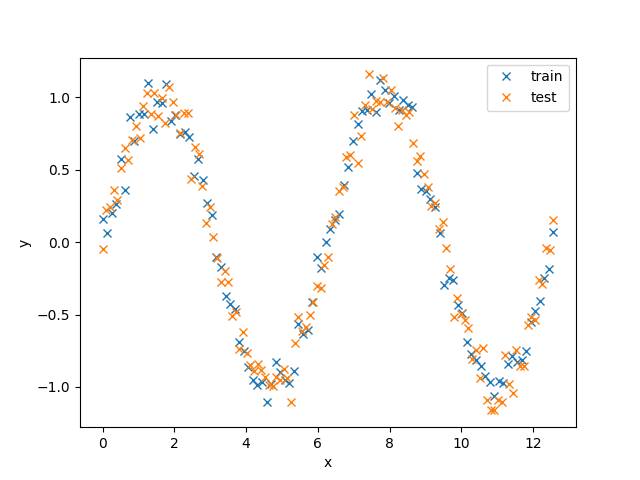

In [14]:
# here is the one-dimensional dataset that we will use
nextplot()
plot1(X1, y1, label="train")
plot1(X1test, y1test, label="test")
plt.legend()

- zero: essentially, a linear regression function. Line Would go through the middle.
- one: 
- two:
- three:

## 2b Train with 2 hidden units

In [15]:
# Training code. You do not need to modify this code.
train_bfgs = lambda model, **kwargs: train_scipy(X1, y1, model, **kwargs)


def train1(hidden_sizes, nreps=10, phi=F.sigmoid, train=train_bfgs, **kwargs):
    """Train an FNN.

    hidden_sizes is a (possibly empty) list containing the sizes of the hidden layer(s).
    nreps refers to the number of repetitions.

    """
    best_model = None
    best_cost = math.inf
    for rep in range(nreps):
        model = MLP([1] + hidden_sizes + [1], phi)  # that's your model!
        print(f"X1 shape: {X1.shape}")
        print(f"Repetition {rep: 2d}: ", end="")
        model = train(model, **kwargs)
        mse = F.mse_loss(y1, model(X1)).item()
        if mse < best_cost:
            best_model = model
            best_cost = mse
        print(f"best_cost={best_cost:.3f}")

    return best_model

In [16]:
# Let's fit the model with one hidden layer consisting of 2 units.
model = train1([2], nreps=10)
print("Training error:", F.mse_loss(y1, model(X1)).item())
print("Test error    :", F.mse_loss(y1test, model(X1test)).item())

X1 shape: torch.Size([100, 1])
Repetition  0:          Current function value: 0.079573
         Iterations: 355
         Function evaluations: 515
         Gradient evaluations: 499
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  1:          Current function value: 0.286909
         Iterations: 350
         Function evaluations: 470
         Gradient evaluations: 461
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  2: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


Optimization terminated successfully.
         Current function value: 0.301865
         Iterations: 156
         Function evaluations: 196
         Gradient evaluations: 196
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  3:          Current function value: 0.079573
         Iterations: 340
         Function evaluations: 474
         Gradient evaluations: 462
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  4:          Current function value: 0.286909
         Iterations: 353
         Function evaluations: 582
         Gradient evaluations: 571
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  5: Optimization terminated successfully.
         Current function value: 0.357250
         Iterations: 83
         Function evaluations: 89
         Gradient evaluations: 89
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  6: Optimization terminated successfully.
         Current function value: 0.357250
         Iterations: 70
         Function evaluatio

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.079572
         Iterations: 432
         Function evaluations: 625
         Gradient evaluations: 609
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  8:          Current function value: 0.079573
         Iterations: 550
         Function evaluations: 867
         Gradient evaluations: 853
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  9:          Current function value: 0.286909
         Iterations: 315
         Function evaluations: 458
         Gradient evaluations: 449
best_cost=0.080
Training error: 0.0795721486210823
Test error    : 0.08671437948942184


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


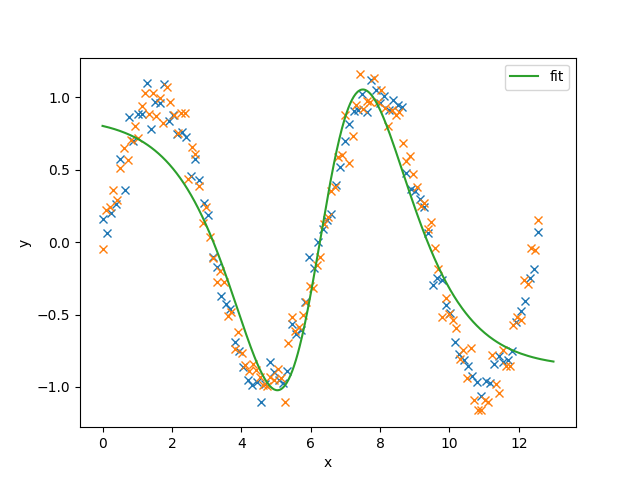

In [17]:
# plot the data and the fit
nextplot()
plot1(X1, y1, label="train")
plot1(X1test, y1test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model)

In [18]:
# The weight matrices and bias vectors can be read out as follows. If you want, use
# these parameters to compute the output of the network (on X1) directly and compare to
# vmap(model)(X1).
for par, value in model.state_dict().items():
    print(f"{par:<15}= {value}")

0_weight       = tensor([[1.0680, 1.0574]])
0_bias         = tensor([-6.7078, -6.6409])
1_weight       = tensor([[ 696.4487],
        [-698.1782]])
1_bias         = tensor([0.8637])


In [19]:
# now repeat this multiple times
models = {
# "model_1_1" : train1([0], nreps=1),
# "model_1_1" : train1([0], nreps=10),
# "model_1_1" : train1([1], nreps=1),
# "model_1_10" : train1([1], nreps=10),
# "model_2_1" : train1([2], nreps=1),
# "model_2_10" : train1([2], nreps=10),
"model_3_1" : train1([3], nreps=1),
"model_3_10" : train1([3], nreps=10)
}

X1 shape: torch.Size([100, 1])
Repetition  0:          Current function value: 0.049879
         Iterations: 445
         Function evaluations: 663
         Gradient evaluations: 652
best_cost=0.050
X1 shape: torch.Size([100, 1])
Repetition  0: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.049878
         Iterations: 527
         Function evaluations: 751
         Gradient evaluations: 740
best_cost=0.050
X1 shape: torch.Size([100, 1])
Repetition  1:          Current function value: 0.049877
         Iterations: 481
         Function evaluations: 650
         Gradient evaluations: 641
best_cost=0.050
X1 shape: torch.Size([100, 1])
Repetition  2:          Current function value: 0.116200
         Iterations: 480
         Function evaluations: 603
         Gradient evaluations: 592
best_cost=0.050
X1 shape: torch.Size([100, 1])
Repetition  3: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.007324
         Iterations: 338
         Function evaluations: 470
         Gradient evaluations: 458
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  4:          Current function value: 0.275464
         Iterations: 453
         Function evaluations: 604
         Gradient evaluations: 593
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  5:          Current function value: 0.049878
         Iterations: 465
         Function evaluations: 614
         Gradient evaluations: 607
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  6: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.049893
         Iterations: 300
         Function evaluations: 418
         Gradient evaluations: 407
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  7:          Current function value: 0.079572
         Iterations: 411
         Function evaluations: 554
         Gradient evaluations: 548
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  8:          Current function value: 0.051868
         Iterations: 269
         Function evaluations: 518
         Gradient evaluations: 504
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  9:          Current function value: 0.079573
         Iterations: 355
         Function evaluations: 595
         Gradient evaluations: 582
best_cost=0.007


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


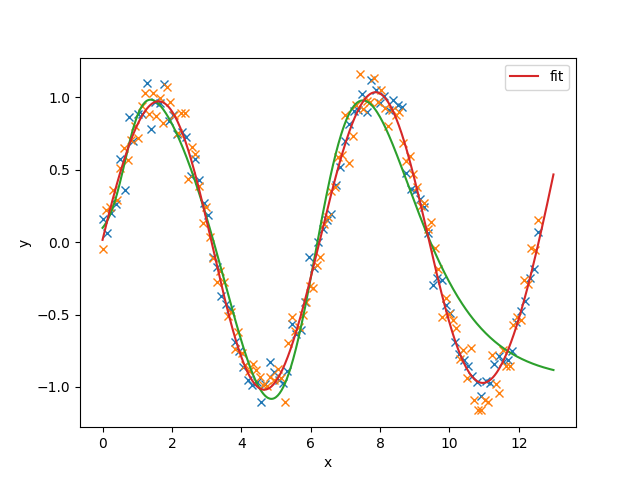

In [20]:
nextplot()
plot1(X1, y1, label="train")
plot1(X1test, y1test, label="test")

for model in models.values():
    plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model)

## 2c Width

In [21]:
# Experiment with different hidden layer sizes. To avoid recomputing
# models, you may want to save your models using torch.save(model, filename) and
# load them again using torch.load(filename).

# Let's fit the model with one hidden layer consisting of 2 units.
model1 = train1([1])
print("Training error:", F.mse_loss(y1, model1(X1)).item())
print("Test error    :", F.mse_loss(y1test, model1(X1test)).item())

torch.save(model1.state_dict(), "./models/model1.pt")


X1 shape: torch.Size([100, 1])
Repetition  0: Optimization terminated successfully.
         Current function value: 0.372919
         Iterations: 41
         Function evaluations: 44
         Gradient evaluations: 44
best_cost=0.373
X1 shape: torch.Size([100, 1])
Repetition  1: Optimization terminated successfully.
         Current function value: 0.372919
         Iterations: 37
         Function evaluations: 49
         Gradient evaluations: 49
best_cost=0.373
X1 shape: torch.Size([100, 1])
Repetition  2: Optimization terminated successfully.
         Current function value: 0.372919
         Iterations: 40
         Function evaluations: 46
         Gradient evaluations: 46
best_cost=0.373
X1 shape: torch.Size([100, 1])
Repetition  3: Optimization terminated successfully.
         Current function value: 0.372919
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
best_cost=0.373
X1 shape: torch.Size([100, 1])
Repetition  4: Optimization termi

In [22]:
model2 = train1([2])
print("Training error:", F.mse_loss(y1, model2(X1)).item())
print("Test error    :", F.mse_loss(y1test, model2(X1test)).item())

torch.save(model2.state_dict(), "./models/model2.pt")

X1 shape: torch.Size([100, 1])
Repetition  0:          Current function value: 0.079572
         Iterations: 464
         Function evaluations: 751
         Gradient evaluations: 738
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  1:          Current function value: 0.079573
         Iterations: 366
         Function evaluations: 509
         Gradient evaluations: 499
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  2: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.079573
         Iterations: 322
         Function evaluations: 464
         Gradient evaluations: 456
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  3:          Current function value: 0.079572
         Iterations: 390
         Function evaluations: 601
         Gradient evaluations: 590
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  4:          Current function value: 0.079573
         Iterations: 380
         Function evaluations: 501
         Gradient evaluations: 489
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  5: Optimization terminated successfully.
         Current function value: 0.302737
         Iterations: 130
         Function evaluations: 145
         Gradient evaluations: 145
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  6: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.079573
         Iterations: 365
         Function evaluations: 492
         Gradient evaluations: 480
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  7:          Current function value: 0.079573
         Iterations: 388
         Function evaluations: 528
         Gradient evaluations: 519
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  8:          Current function value: 0.079573
         Iterations: 356
         Function evaluations: 528
         Gradient evaluations: 516
best_cost=0.080
X1 shape: torch.Size([100, 1])
Repetition  9:          Current function value: 0.079573
         Iterations: 370
         Function evaluations: 494
         Gradient evaluations: 482
best_cost=0.080
Training error: 0.0795714259147644
Test error    : 0.08671518415212631


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [23]:
model3= train1([3])
print("Training error:", F.mse_loss(y1, model3(X1)).item())
print("Test error    :", F.mse_loss(y1test, model3(X1test)).item())

torch.save(model3.state_dict(), "./models/model3.pt")

X1 shape: torch.Size([100, 1])
Repetition  0:          Current function value: 0.049877
         Iterations: 484
         Function evaluations: 642
         Gradient evaluations: 632
best_cost=0.050
X1 shape: torch.Size([100, 1])
Repetition  1: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.049877
         Iterations: 584
         Function evaluations: 784
         Gradient evaluations: 772
best_cost=0.050
X1 shape: torch.Size([100, 1])
Repetition  2:          Current function value: 0.008496
         Iterations: 456
         Function evaluations: 685
         Gradient evaluations: 668
best_cost=0.008
X1 shape: torch.Size([100, 1])
Repetition  3: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.053382
         Iterations: 511
         Function evaluations: 759
         Gradient evaluations: 748
best_cost=0.008
X1 shape: torch.Size([100, 1])
Repetition  4:          Current function value: 0.007324
         Iterations: 595
         Function evaluations: 806
         Gradient evaluations: 792
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  5:          Current function value: 0.371771
         Iterations: 327
         Function evaluations: 470
         Gradient evaluations: 458
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  6: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.007792
         Iterations: 389
         Function evaluations: 608
         Gradient evaluations: 593
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  7:          Current function value: 0.051894
         Iterations: 419
         Function evaluations: 539
         Gradient evaluations: 527
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  8:          Current function value: 0.049877
         Iterations: 502
         Function evaluations: 628
         Gradient evaluations: 617
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  9:          Current function value: 0.007324
         Iterations: 354
         Function evaluations: 451
         Gradient evaluations: 439
best_cost=0.007
Training error: 0.007324240170419216
Test error    : 0.010335271246731281


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [24]:
model10= train1([10])
print("Training error:", F.mse_loss(y1, model10(X1)).item())
print("Test error    :", F.mse_loss(y1test, model10(X1test)).item())

torch.save(model10.state_dict(), "./models/model10.pt")

X1 shape: torch.Size([100, 1])
Repetition  0: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.006654
         Iterations: 1923
         Function evaluations: 2408
         Gradient evaluations: 2393
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  1: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.005709
         Iterations: 2753
         Function evaluations: 3149
         Gradient evaluations: 3136
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  2: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.006452
         Iterations: 3022
         Function evaluations: 3425
         Gradient evaluations: 3414
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  3: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.005936
         Iterations: 2293
         Function evaluations: 2601
         Gradient evaluations: 2590
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  4: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.006493
         Iterations: 2748
         Function evaluations: 3173
         Gradient evaluations: 3157
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  5: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.006827
         Iterations: 1563
         Function evaluations: 1819
         Gradient evaluations: 1807
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  6: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.006237
         Iterations: 3076
         Function evaluations: 3478
         Gradient evaluations: 3467
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  7: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.006660
         Iterations: 1110
         Function evaluations: 1305
         Gradient evaluations: 1294
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  8:          Current function value: 0.006638
         Iterations: 1792
         Function evaluations: 2141
         Gradient evaluations: 2130
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  9:          Current function value: 0.006652
         Iterations: 863
         Function evaluations: 1093
         Gradient evaluations: 1081
best_cost=0.006
Training error: 0.005708649288862944
Test error    : 0.023016968742012978


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [25]:
model50= train1([50])
print("Training error:", F.mse_loss(y1, model50(X1)).item())
print("Test error    :", F.mse_loss(y1test, model50(X1test)).item())

torch.save(model50.state_dict(), "./models/model50.pt")

X1 shape: torch.Size([100, 1])
Repetition  0: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.004760
         Iterations: 3795
         Function evaluations: 4283
         Gradient evaluations: 4272
best_cost=0.005
X1 shape: torch.Size([100, 1])
Repetition  1: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.004108
         Iterations: 5131
         Function evaluations: 5687
         Gradient evaluations: 5676
best_cost=0.004
X1 shape: torch.Size([100, 1])
Repetition  2: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.004358
         Iterations: 4048
         Function evaluations: 4494
         Gradient evaluations: 4486
best_cost=0.004
X1 shape: torch.Size([100, 1])
Repetition  3: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.002975
         Iterations: 6598
         Function evaluations: 7335
         Gradient evaluations: 7322
best_cost=0.003
X1 shape: torch.Size([100, 1])
Repetition  4: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.003348
         Iterations: 4949
         Function evaluations: 5502
         Gradient evaluations: 5492
best_cost=0.003
X1 shape: torch.Size([100, 1])
Repetition  5: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.004299
         Iterations: 10000
         Function evaluations: 10844
         Gradient evaluations: 10844
best_cost=0.003
X1 shape: torch.Size([100, 1])
Repetition  6: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.003333
         Iterations: 5263
         Function evaluations: 5736
         Gradient evaluations: 5726
best_cost=0.003
X1 shape: torch.Size([100, 1])
Repetition  7: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.004762
         Iterations: 2570
         Function evaluations: 2906
         Gradient evaluations: 2894
best_cost=0.003
X1 shape: torch.Size([100, 1])
Repetition  8: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.003223
         Iterations: 7202
         Function evaluations: 7949
         Gradient evaluations: 7930
best_cost=0.003
X1 shape: torch.Size([100, 1])
Repetition  9:          Current function value: 0.004972
         Iterations: 3782
         Function evaluations: 4249
         Gradient evaluations: 4238
best_cost=0.003
Training error: 0.002975039416924119
Test error    : 0.068841353058815


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [26]:
model100= train1([100])
print("Training error:", F.mse_loss(y1, model100(X1)).item())
print("Test error    :", F.mse_loss(y1test, model100(X1test)).item())

torch.save(model100.state_dict(), "./models/model100.pt")

X1 shape: torch.Size([100, 1])
Repetition  0: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.004656
         Iterations: 3504
         Function evaluations: 3996
         Gradient evaluations: 3984
best_cost=0.005
X1 shape: torch.Size([100, 1])
Repetition  1: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.002520
         Iterations: 8639
         Function evaluations: 9477
         Gradient evaluations: 9464
best_cost=0.003
X1 shape: torch.Size([100, 1])
Repetition  2: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.003220
         Iterations: 5656
         Function evaluations: 6289
         Gradient evaluations: 6275
best_cost=0.003
X1 shape: torch.Size([100, 1])
Repetition  3: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.001788
         Iterations: 10000
         Function evaluations: 10769
         Gradient evaluations: 10769
best_cost=0.002
X1 shape: torch.Size([100, 1])
Repetition  4:          Current function value: 0.002305
         Iterations: 10000
         Function evaluations: 10653
         Gradient evaluations: 10653
best_cost=0.002
X1 shape: torch.Size([100, 1])
Repetition  5: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.003947
         Iterations: 3706
         Function evaluations: 4161
         Gradient evaluations: 4149
best_cost=0.002
X1 shape: torch.Size([100, 1])
Repetition  6: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.003632
         Iterations: 5133
         Function evaluations: 5907
         Gradient evaluations: 5894
best_cost=0.002
X1 shape: torch.Size([100, 1])
Repetition  7: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.003517
         Iterations: 9020
         Function evaluations: 9972
         Gradient evaluations: 9961
best_cost=0.002
X1 shape: torch.Size([100, 1])
Repetition  8: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.001982
         Iterations: 9906
         Function evaluations: 10761
         Gradient evaluations: 10749
best_cost=0.002
X1 shape: torch.Size([100, 1])
Repetition  9:          Current function value: 0.002907
         Iterations: 7061
         Function evaluations: 7670
         Gradient evaluations: 7660
best_cost=0.002
Training error: 0.0017877757782116532
Test error    : 0.7997748851776123


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [27]:
model1 = (MLP([1] + [1] + [1], F.sigmoid))
model1.load_state_dict(torch.load('./models/model1.pt'))

model2 = (MLP([1] + [2] + [1], F.sigmoid))
model2.load_state_dict(torch.load('./models/model2.pt'))

model3 = (MLP([1] + [3] + [1], F.sigmoid))
model3.load_state_dict(torch.load('./models/model3.pt'))

model10 = (MLP([1] + [10] + [1], F.sigmoid))
model10.load_state_dict(torch.load('./models/model10.pt'))

model50 = (MLP([1] + [50] + [1], F.sigmoid))
model50.load_state_dict(torch.load('./models/model50.pt'))

model100 = (MLP([1] + [100] + [1], F.sigmoid))
model100.load_state_dict(torch.load('./models/model100.pt'))

<All keys matched successfully>

In [28]:
model1

MLP()

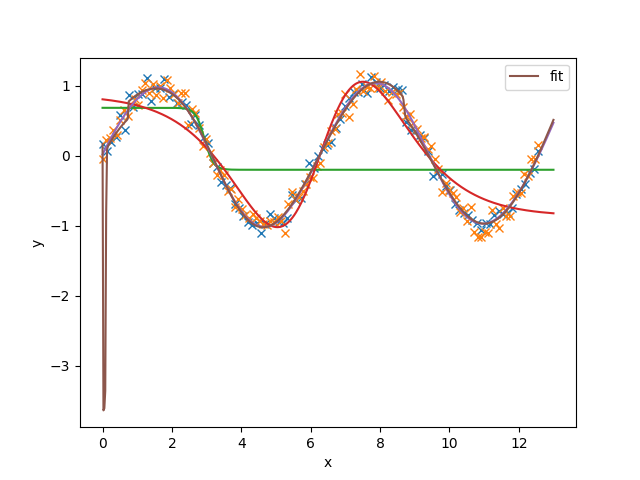

In [29]:
nextplot()
plot1(X1, y1, label="train")
plot1(X1test, y1test, label="test")

plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model1)
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model2)
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model3)
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model10)


## 2d Distributed representations

In [30]:
# train a model to analyze
model = train1([3])

X1 shape: torch.Size([100, 1])
Repetition  0:          Current function value: 0.049878
         Iterations: 452
         Function evaluations: 648
         Gradient evaluations: 635
best_cost=0.050
X1 shape: torch.Size([100, 1])
Repetition  1:          Current function value: 0.051086
         Iterations: 474
         Function evaluations: 637
         Gradient evaluations: 627
best_cost=0.050
X1 shape: torch.Size([100, 1])
Repetition  2: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily a

         Current function value: 0.007324
         Iterations: 559
         Function evaluations: 779
         Gradient evaluations: 766
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  3:          Current function value: 0.049882
         Iterations: 283
         Function evaluations: 463
         Gradient evaluations: 446
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  4:          Current function value: 0.007324
         Iterations: 672
         Function evaluations: 875
         Gradient evaluations: 862
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  5: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.007324
         Iterations: 554
         Function evaluations: 688
         Gradient evaluations: 676
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  6:          Current function value: 0.007324
         Iterations: 313
         Function evaluations: 530
         Gradient evaluations: 516
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  7:          Current function value: 0.007324
         Iterations: 295
         Function evaluations: 407
         Gradient evaluations: 395
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  8:          Current function value: 0.007324
         Iterations: 394
         Function evaluations: 523
         Gradient evaluations: 510
best_cost=0.007
X1 shape: torch.Size([100, 1])
Repetition  9:          Current function value: 0.079573
         Iterations: 406
         Function evaluations: 555
         Gradient evaluations: 543
best_cost=0.007


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


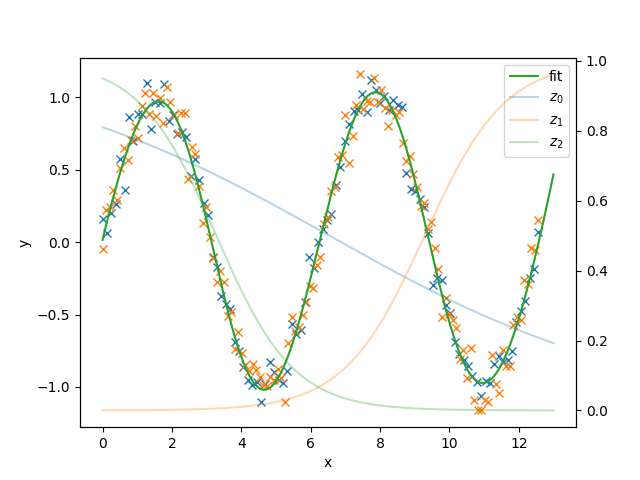

In [31]:
# plot the fit as well as the outputs of each neuron in the hidden
# layer (scale for the latter is shown on right y-axis)
nextplot()
plot1(X1, y1, label="train")
plot1(X1test, y1test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model, hidden=True, scale=False)

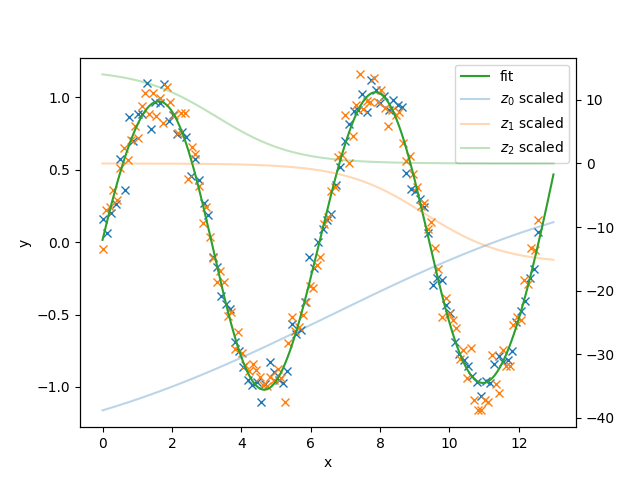

In [32]:
# plot the fit as well as the outputs of each neuron in the hidden layer, scaled
# by its weight for the output neuron (scale for the latter is shown on right
# y-axis)

nextplot()
plot1(X1, y1, label="train")
plot1(X1test, y1test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model, hidden=True, scale=True)

## 2e Experiment with different optimizers (optional)

In [33]:
# PyTorch provides many gradient-based optimizers; see
# https://pytorch.org/docs/stable/optim.html. You can use a PyTorch optimizer
# as follows.
train_adam = lambda model, **kwargs: fnn_train(
    X1, y1, model, optimizer=torch.optim.Adam(model.parameters(), lr=0.01), **kwargs
)
model = train1([50], nreps=1, train=train_adam, max_epochs=5000, tol=1e-8, verbose=True)

X1 shape: torch.Size([100, 1])
Repetition  0: Epoch     0: cost=   1.293 
Epoch     1: cost=   0.855 
Epoch     2: cost=   0.581 
Epoch     3: cost=   0.463 
Epoch     4: cost=   0.468 
Epoch     5: cost=   0.539 
Epoch     6: cost=   0.612 
Epoch     7: cost=   0.646 
Epoch     8: cost=   0.633 
Epoch     9: cost=   0.589 
Epoch    10: cost=   0.533 
Epoch    11: cost=   0.483 
Epoch    12: cost=   0.451 
Epoch    13: cost=   0.440 
Epoch    14: cost=   0.448 
Epoch    15: cost=   0.467 
Epoch    16: cost=   0.486 
Epoch    17: cost=   0.498 
Epoch    18: cost=   0.499 
Epoch    19: cost=   0.489 
Epoch    20: cost=   0.473 
Epoch    21: cost=   0.456 
Epoch    22: cost=   0.442 
Epoch    23: cost=   0.435 
Epoch    24: cost=   0.435 
Epoch    25: cost=   0.440 
Epoch    26: cost=   0.447 
Epoch    27: cost=   0.452 
Epoch    28: cost=   0.454 
Epoch    29: cost=   0.451 
Epoch    30: cost=   0.445 
Epoch    31: cost=   0.438 
Epoch    32: cost=   0.432 
Epoch    33: cost=   0.429 
Ep

X1 shape: torch.Size([100, 1])
Repetition  0: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.081754
         Iterations: 197
         Function evaluations: 330
         Gradient evaluations: 324
best_cost=0.082
X1 shape: torch.Size([100, 1])
Repetition  1:          Current function value: 0.309341
         Iterations: 47
         Function evaluations: 174
         Gradient evaluations: 166
best_cost=0.082
X1 shape: torch.Size([100, 1])
Repetition  2:          Current function value: 0.021929
         Iterations: 48
         Function evaluations: 133
         Gradient evaluations: 127
best_cost=0.022
X1 shape: torch.Size([100, 1])
Repetition  3: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.082625
         Iterations: 94
         Function evaluations: 176
         Gradient evaluations: 169
best_cost=0.022
X1 shape: torch.Size([100, 1])
Repetition  4:          Current function value: 0.089863
         Iterations: 120
         Function evaluations: 226
         Gradient evaluations: 220
best_cost=0.022
X1 shape: torch.Size([100, 1])
Repetition  5: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.082474
         Iterations: 39
         Function evaluations: 129
         Gradient evaluations: 126
best_cost=0.022
X1 shape: torch.Size([100, 1])
Repetition  6:          Current function value: 0.098277
         Iterations: 132
         Function evaluations: 207
         Gradient evaluations: 203
best_cost=0.022
X1 shape: torch.Size([100, 1])
Repetition  7: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.098335
         Iterations: 99
         Function evaluations: 203
         Gradient evaluations: 198
best_cost=0.022
X1 shape: torch.Size([100, 1])
Repetition  8: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.084660
         Iterations: 63
         Function evaluations: 150
         Gradient evaluations: 143
best_cost=0.022
X1 shape: torch.Size([100, 1])
Repetition  9: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.008690
         Iterations: 159
         Function evaluations: 265
         Gradient evaluations: 258
best_cost=0.009
X1 shape: torch.Size([100, 1])
Repetition  10: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.011249
         Iterations: 201
         Function evaluations: 311
         Gradient evaluations: 309
best_cost=0.009
X1 shape: torch.Size([100, 1])
Repetition  11:          Current function value: 0.356422
         Iterations: 75
         Function evaluations: 170
         Gradient evaluations: 166
best_cost=0.009
X1 shape: torch.Size([100, 1])
Repetition  12:          Current function value: 0.356366
         Iterations: 63
         Function evaluations: 157
         Gradient evaluations: 152
best_cost=0.009
X1 shape: torch.Size([100, 1])
Repetition  13: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.082331
         Iterations: 81
         Function evaluations: 196
         Gradient evaluations: 190
best_cost=0.009
X1 shape: torch.Size([100, 1])
Repetition  14: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.008332
         Iterations: 214
         Function evaluations: 393
         Gradient evaluations: 381
best_cost=0.008
X1 shape: torch.Size([100, 1])
Repetition  15: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.356475
         Iterations: 82
         Function evaluations: 181
         Gradient evaluations: 178
best_cost=0.008
X1 shape: torch.Size([100, 1])
Repetition  16:          Current function value: 0.011342
         Iterations: 188
         Function evaluations: 319
         Gradient evaluations: 307
best_cost=0.008
X1 shape: torch.Size([100, 1])
Repetition  17: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.355779
         Iterations: 67
         Function evaluations: 164
         Gradient evaluations: 159
best_cost=0.008
X1 shape: torch.Size([100, 1])
Repetition  18:          Current function value: 0.084557
         Iterations: 96
         Function evaluations: 230
         Gradient evaluations: 223
best_cost=0.008
X1 shape: torch.Size([100, 1])
Repetition  19: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.013663
         Iterations: 89
         Function evaluations: 205
         Gradient evaluations: 193
best_cost=0.008
X1 shape: torch.Size([100, 1])
Repetition  20:          Current function value: 0.355771
         Iterations: 97
         Function evaluations: 192
         Gradient evaluations: 185
best_cost=0.008
X1 shape: torch.Size([100, 1])
Repetition  21: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.008507
         Iterations: 199
         Function evaluations: 414
         Gradient evaluations: 402
best_cost=0.008
X1 shape: torch.Size([100, 1])
Repetition  22:          Current function value: 0.084680
         Iterations: 65
         Function evaluations: 149
         Gradient evaluations: 143
best_cost=0.008
X1 shape: torch.Size([100, 1])
Repetition  23: Optimization terminated successfully.
         Current function value: 0.506238
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
best_cost=0.008
X1 shape: torch.Size([100, 1])
Repetition  24:          Current function value: 0.355875
         Iterations: 83
         Function evaluations: 189
         Gradient evaluations: 182
best_cost=0.008
X1 shape: torch.Size([100, 1])
Repetition  25: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.006384
         Iterations: 112
         Function evaluations: 216
         Gradient evaluations: 209
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  26:          Current function value: 0.356134
         Iterations: 58
         Function evaluations: 164
         Gradient evaluations: 156
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  27:          Current function value: 0.357622
         Iterations: 36
         Function evaluations: 116
         Gradient evaluations: 110
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  28:          Current function value: 0.398953
         Iterations: 20
         Function evaluations: 115
         Gradient evaluations: 109
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  29: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.356162
         Iterations: 45
         Function evaluations: 156
         Gradient evaluations: 154
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  30:          Current function value: 0.355884
         Iterations: 79
         Function evaluations: 185
         Gradient evaluations: 181
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  31:          Current function value: 0.098431
         Iterations: 51
         Function evaluations: 134
         Gradient evaluations: 128
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  32: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.355989
         Iterations: 86
         Function evaluations: 181
         Gradient evaluations: 177
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  33: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.006600
         Iterations: 307
         Function evaluations: 433
         Gradient evaluations: 421
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  34:          Current function value: 0.357715
         Iterations: 28
         Function evaluations: 138
         Gradient evaluations: 131
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  35:          Current function value: 0.355809
         Iterations: 94
         Function evaluations: 180
         Gradient evaluations: 176
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  36: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.023239
         Iterations: 108
         Function evaluations: 223
         Gradient evaluations: 212
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  37:          Current function value: 0.355985
         Iterations: 62
         Function evaluations: 169
         Gradient evaluations: 166
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  38: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.082410
         Iterations: 46
         Function evaluations: 133
         Gradient evaluations: 123
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  39:          Current function value: 0.008140
         Iterations: 86
         Function evaluations: 172
         Gradient evaluations: 165
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  40: Optimization terminated successfully.
         Current function value: 0.506238
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  41:          Current function value: 0.351567
         Iterations: 14
         Function evaluations: 112
         Gradient evaluations: 101
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  42: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.011727
         Iterations: 96
         Function evaluations: 177
         Gradient evaluations: 172
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  43:          Current function value: 0.008865
         Iterations: 152
         Function evaluations: 273
         Gradient evaluations: 266
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  44: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.355520
         Iterations: 96
         Function evaluations: 201
         Gradient evaluations: 196
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  45:          Current function value: 0.356199
         Iterations: 74
         Function evaluations: 172
         Gradient evaluations: 166
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  46:          Current function value: 0.084039
         Iterations: 66
         Function evaluations: 130
         Gradient evaluations: 125
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  47: 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.311066
         Iterations: 28
         Function evaluations: 134
         Gradient evaluations: 130
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  48:          Current function value: 0.013557
         Iterations: 162
         Function evaluations: 311
         Gradient evaluations: 302
best_cost=0.006
X1 shape: torch.Size([100, 1])
Repetition  49:          Current function value: 0.356307
         Iterations: 91
         Function evaluations: 212
         Gradient evaluations: 207
best_cost=0.006
Training error: 0.006383862346410751
Test error    : 0.010709108784794807


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


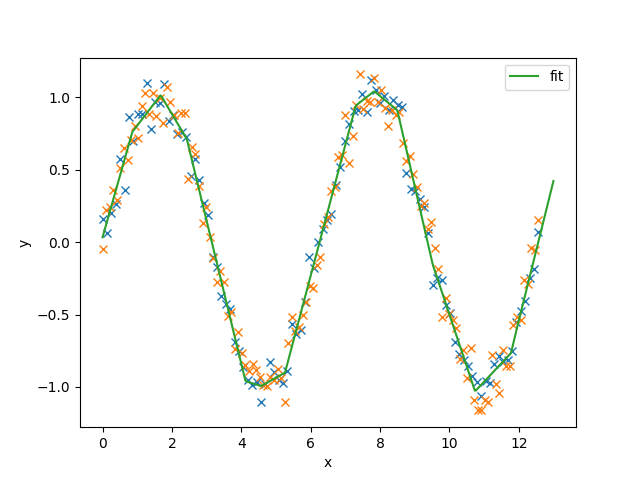

In [34]:
# Experiment with different number of layers and activation functions. Here is
# an example with three hidden layers (of sizes 4, 5, and 6) and ReLU activations.
#
# You can also plot the outputs of the hidden neurons in the first layer (using
# the same code above).
model = train1([4, 5, 6], nreps=50, phi=F.relu)
nextplot()
plot1(X1, y1, label="train")
plot1(X1test, y1test, label="test")
plot1fit(torch.linspace(0, 13, 500).unsqueeze(1), model)
print("Training error:", F.mse_loss(y1, model(X1)).item())
print("Test error    :", F.mse_loss(y1test, model(X1test)).item())

# 3 Backpropagation

In [35]:
# Let's fit the model with one hidden layer consisting of 50 units.
model = train1([50], nreps=1)
print("Training error:", F.mse_loss(y1, model(X1)).item())
print("Test error    :", F.mse_loss(y1test, model(X1test)).item())

# Extract parameters
pars = dict(model.named_parameters())
W1 = pars["0_weight"].data  # 1x50
b1 = pars["0_bias"].data  # 50
W2 = pars["1_weight"].data  # 50x1
b2 = pars["1_bias"].data  # 1

X1 shape: torch.Size([100, 1])
Repetition  0:          Current function value: 0.004334
         Iterations: 3134
         Function evaluations: 3482
         Gradient evaluations: 3471
best_cost=0.004
Training error: 0.004333504009991884
Test error    : 0.10483711957931519


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


## 3a Forward pass

In [36]:
# Compute results of forward pass on an example x (i.e., z1, z2, z3, z4, yhat, l) using Pytorch
x = X1test[1, :]
y = y1test[1, :]
print(f"x={x}, y={y}, yhat={model(x).detach()}, l={torch.nn.MSELoss()(y,model(x))}")

x=tensor([0.1030]), y=tensor([0.2253]), yhat=tensor([0.6503]), l=0.1806761771440506


In [37]:
# Now do this by hand (including all intermediate values). You should get the same
# results as above.

def compute_loss(y, y_hat):
    return torch.square(y - y_hat)

# Compute the forward pass
def forward_pass(x, y, W1, b1, W2, b2):
    z1 = torch.matmul(x, W1) 
    z2 = z1 + b1
    z3 = torch.sigmoid(z2)
    z4 = torch.matmul(z3, W2)
    y_hat = z4 + b2

    loss = compute_loss(y, y_hat)
    return z1, z2, z3, z4, y_hat, loss

In [38]:
z1, z2, z3, z4, y_hat, loss = forward_pass(x, y, W1, b1, W2, b2)
print(f"x={x}, y={y}, yhat={y_hat}, l={loss}")

x=tensor([0.1030]), y=tensor([0.2253]), yhat=tensor([0.6503]), l=tensor([0.1807])


## 3b Backward pass

In [39]:
# Define the sigmoid derivative function
def sigmoid_derivative(z):
    return torch.sigmoid(z) * (1 - torch.sigmoid(z))

# Compute the backward pass
def backward_pass(x, y, y_hat, z1, z2, z3, z4, W1, W2):
    delta_l = 1
    delta_y = 2 * (y - y_hat)
    delta_yhat = -delta_y
    delta_b2 = delta_yhat
    delta_z4 = delta_yhat
    delta_W2 = torch.matmul(z3.view(-1, 1), delta_z4.view(1, -1))
    delta_z3 = torch.matmul(delta_z4, W2.t())
    delta_z2 = delta_z3 * sigmoid_derivative(z2)
    delta_b1 = delta_z2
    delta_z1 = delta_z2
    delta_W1 = torch.matmul(x.view(-1, 1), delta_z1.view(1, -1))
    delta_x = torch.matmul(delta_z1, W1.t())
    return delta_x, delta_W1, delta_z1, delta_b1, delta_z2, delta_z3, delta_W2, delta_z4, delta_b2, delta_yhat, delta_l, delta_y

# Compute the forward pass
z1, z2, z3, z4, y_hat, loss = forward_pass(x, y, W1, b1, W2, b2)

# Compute the backward pass
delta_x, delta_W1, delta_z1, delta_b1, delta_z2, delta_z3, delta_W2, delta_z4, delta_b2, delta_yhat, delta_l, delta_y = backward_pass(x, y, y_hat, z1, z2, z3, z4, W1, W2)

# Print the results
print(f"delta_x={delta_x}, delta_W1={delta_W1}, delta_z1={delta_z1}, delta_b1={delta_b1}, delta_z2={delta_z2}, delta_z3={delta_z3}, delta_W2={delta_W2}, delta_z4={delta_z4}, delta_b2={delta_b2}, delta_yhat={delta_yhat}, delta_l={delta_l}, delta_y={delta_y}")

delta_x=tensor([-20.9734]), delta_W1=tensor([[ 0.0000e+00, -4.3993e-03,  2.0819e-09,  4.7660e-02, -2.8263e-05,
         -4.8608e-04, -1.3967e-06, -2.2605e-15,  0.0000e+00,  4.4104e-04,
          0.0000e+00, -6.3388e-06,  1.8026e-14,  1.6355e-04,  9.7090e-03,
         -2.4882e-04, -8.1696e-04,  8.4093e-02,  9.5691e-01,  9.6889e-02,
          8.8105e-23,  4.8536e-02, -1.8675e-02,  1.6144e-02,  0.0000e+00,
         -1.8485e-04,  1.8666e-02,  7.2736e-02,  0.0000e+00, -1.1733e-03,
          0.0000e+00, -9.2435e-04,  2.0513e-01, -2.7506e-02,  0.0000e+00,
          8.6051e-03, -6.9187e-07,  2.6708e-05,  1.9279e-04, -1.0991e-08,
          1.5862e-02,  9.6670e-12,  0.0000e+00, -1.5265e-02, -4.7806e-04,
          2.0439e-01,  1.4143e-02,  1.0092e-02,  2.6828e-05,  0.0000e+00]]), delta_z1=tensor([-0.0000e+00, -4.2710e-02,  2.0212e-08,  4.6270e-01, -2.7439e-04,
        -4.7191e-03, -1.3560e-05, -2.1946e-14, -0.0000e+00,  4.2818e-03,
        -0.0000e+00, -6.1540e-05,  1.7501e-13,  1.5878e-03,  9.42

In [40]:
# Use PyTorch's backprop
x.requires_grad = True
y.requires_grad = True
if x.grad is not None:
    x.grad.zero_()
if y.grad is not None:
    y.grad.zero_()
model.zero_grad()
t_yhat = model(x)
t_yhat.retain_grad()
t_l = torch.nn.MSELoss()(t_yhat, y)
t_l.backward()
t_delta_l = 1
t_delta_y = y.grad
t_delta_yhat = t_yhat.grad
t_delta_b2 = model.get_parameter("1_bias").grad
t_delta_W2 = model.get_parameter("1_weight").grad
t_delta_b1 = model.get_parameter("0_bias").grad
t_delta_W1 = model.get_parameter("0_weight").grad
t_delta_x = x.grad

In [41]:
# Check if equal (show squared error)
for v in ["y", "yhat", "b2", "W2", "b1", "W1", "x"]:
    print(f'{v}, squared error={torch.sum((eval("t_delta_"+v)-eval("delta_"+v))**2)}')

y, squared error=0.0
yhat, squared error=0.0
b2, squared error=0.0
W2, squared error=0.0
b1, squared error=9.111188366273115e-13
W1, squared error=3.575489124202748e-15
x, squared error=0.0


In [42]:
# Check if equal (show actual values)
for v in ["l", "y", "yhat", "b2", "W2", "b1", "W1", "x"]:
    print(f'{v}, pytorch={eval("t_delta_"+v)}, you={eval("delta_"+v)}')

l, pytorch=1, you=1
y, pytorch=tensor([-0.8501]), you=tensor([-0.8501])
yhat, pytorch=tensor([0.8501]), you=tensor([0.8501])
b2, pytorch=tensor([0.8501]), you=tensor([0.8501])
W2, pytorch=tensor([[8.5012e-01],
        [2.1987e-01],
        [1.0398e-09],
        [8.1319e-01],
        [8.7667e-05],
        [8.4992e-01],
        [8.5012e-01],
        [1.9375e-16],
        [8.5012e-01],
        [8.4991e-01],
        [8.5012e-01],
        [8.5012e-01],
        [5.7552e-15],
        [3.5934e-05],
        [8.4553e-01],
        [2.8686e-04],
        [1.5995e-03],
        [3.8704e-02],
        [4.0949e-01],
        [7.4062e-01],
        [3.4677e-23],
        [7.7456e-01],
        [2.0643e-02],
        [7.7037e-01],
        [8.5012e-01],
        [8.5001e-01],
        [7.9088e-01],
        [6.0853e-01],
        [8.5012e-01],
        [1.6800e-04],
        [8.5012e-01],
        [8.4879e-01],
        [4.9397e-01],
        [1.6477e-01],
        [8.5012e-01],
        [4.9932e-02],
        [8.5012e-01]